# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Confidence intervals 

#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2022

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing modules

In [16]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [17]:
# REMEMBER TO ADD your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [18]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Goal

  **Estimate the Confidence Interval of the half-life.**
  
  **Observation or discovery?**

### Indications

   * Compute the likelihood scan, and compute the confidence intervals
   
   * Compute the test statistics for the null hipothesis (no signal events) and its p-value.
   

## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


## Access the data

In [6]:
filename = '/data/fanal_' + coll +'.h5'
print('Data : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

Data :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


In [7]:
samples  = ['bb0nu', 'Bi', 'Tl']
ssamples = [r'$\beta\beta0\nu$', r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbb, mcbi, mctl]

## Estimate the number of events

In [8]:
from collpars import nevts_Bi, unevts_Bi
from collpars import nevts_Tl, unevts_Tl
nevts  = (10   , nevts_Bi , nevts_Tl)
unevts = (False, unevts_Bi, unevts_Tl)

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 15
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
Initial       Events :   5.19,   2.60,   8.13
Uncertainties Events :   0.00,   0.32,   0.15
Fit success          :  True
Estimated     Events :   3.93,   2.58,   8.13


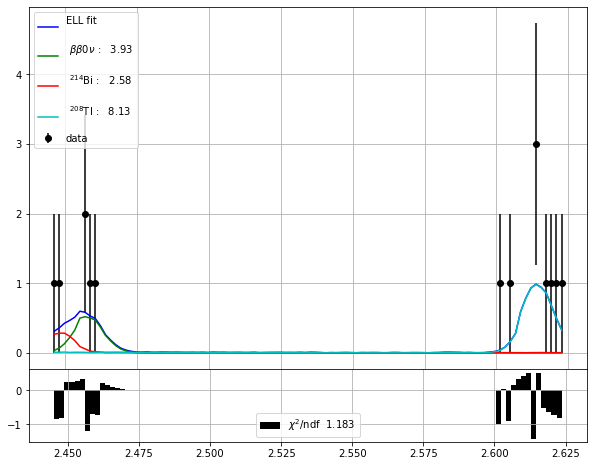

In [9]:
result, enes, ell, pdfs = fn.ana_experiment(data, mcs, nevts, unevts, bins = 180)
ns_esp   = result.x   # number of estimated events
nevts_bb = ns_esp[0]  # number of bb events

### Compute the half-life

In [10]:
anadata, anamcs, effs = fn.ana_samples(data, mcs) 
eff_bb     = effs[0]
nevts_bb   = ns_esp[0]
acc_bb     = collpars.acc_bb
exposure   = collpars.exposure
eff        = acc_bb * eff_bb
tau        = fn.half_life(nevts_bb, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))
#TODO: uncertainties

selection variables  : ['E', 'num_tracks', 'blob2_E']
selection ranges     : [(2.4, 2.65), (1.0, 1.1), (0.4, inf)]
selection mc samples : ['E', 'num_tracks']
data size            : 15
mc sizes             : [30217, 6688, 31607]
efficiencies         :   0.52, 1.76e-02, 7.28e-03
number of bb0nu events  :  3.934
exposure                : 500.00 kg y
total signal efficiency :  0.412
bb0nu half-life         : 1.45e+26 y 


## Confidence interval

We compute the confidence intervals using the log likelihood profile.

We consider that conditions of Wilks theorem conditions are fulfill. 

If the parameters are in the 'gaussian' domain the conditions are fulfilled. 

If they are not, the distributions of the $t_\mu(x)$ needs to be obtained using simulated experiments.

Here for simplicity we asume they are. This is an "aceptable" solution for this exercise.


In the Wilks regime, there is a simple relation between the -2 log likelihood ration, $t_\mu(x)$:

$$
t_\mu(x) = -2 \log \frac{\mathcal{L}(x|\mu)}{\mathcal{L}(x| \hat{\mu}(x))}
$$

and the p-value, $p$

$$
p = \int_{t_\mu}^\infty g(t'_\mu | n) \, \mathrm{d}t'_\mu=
$$

where $g(t_\mu |n)$ is the pdf of the $\chi^2$ wiht $n=1$ degrees of freedom. 

In that case there is a tabulation between $t_\mu(x)$ and the $p$, the p-value.

## Compute CI

The limits of the CI intervals correspond to the $\mu$ values where $t_\mu(x) = 1$ for 68 % CL.


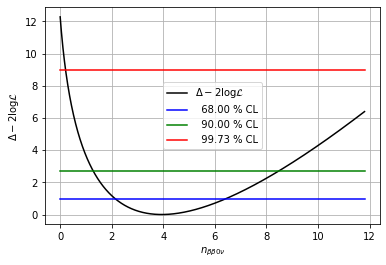

In [11]:
nbins  = 1000
nmus   = np.linspace(0, 3 * nevts_bb, nbins) 
llbest = - 2 * ell.loglike(enes, *ns_esp)
dlls   = [-2 * ell.loglike(enes, nmu, *ns_esp[1:]) - llbest for nmu in nmus]
plt.plot(nmus, dlls, label = r"$\Delta -2 \mathrm{log} \mathcal{L}$");

Z3 = 0.0027
Z5 = 2.87e-7
pvalues = [0.68, 0.9, 1-Z3]
cis = []
for pvalue in pvalues:
    ti = stats.chi2.ppf(pvalue, 1)
    plt.plot(nmus, ti * np.ones(nbins), label = ' {:6.2f} % CL'.format(100 * pvalue))
    xsel = dlls < ti
    ci = np.min(nmus[xsel]), np.max(nmus[xsel])
    cis.append(ci)
plt.legend(); plt.grid(); plt.xlabel(r'$n_{\beta\beta0\nu}$'); plt.ylabel("$\Delta -2 \mathrm{log} \mathcal{L}$");

Translate the CI in number of bb0nu events into CI in the half-life

In [12]:
tau_cis = []
for ci, pvalue in zip(cis, pvalues):
    tau_ci = [fn.half_life(ni, exposure, eff) for ni in ci]
    tau_ci.reverse()
    tau_cis.append(tau_ci)

for i, pvalue in enumerate(pvalues):
    print('Number events CI ({:6.3f}, {:6.3f}) at {:6.2f} % CL'.format(*cis[i]    , 100 * pvalue))
    
for i, pvalue in enumerate(pvalues):
    print('tau (y)       CI ({:1.2e}, {:1.2e}) at {:6.2f} % CL'.format(*tau_cis[i], 100 * pvalue))

Number events CI ( 2.138,  6.426) at  68.00 % CL
Number events CI ( 1.288,  8.470) at  90.00 % CL
Number events CI ( 0.213, 11.801) at  99.73 % CL
tau (y)       CI (8.86e+25, 2.66e+26) at  68.00 % CL
tau (y)       CI (6.73e+25, 4.42e+26) at  90.00 % CL
tau (y)       CI (4.83e+25, 2.68e+27) at  99.73 % CL


## Observation or Discovery?

Conditions:

   * Observation, p-value of the null hipothesis is 3Z, $p > 0.0027$
   * Discovery, p-value of the null hipothesis is 5Z, $p > 2.87 \; 10^{-7}$

We consider that we are in the "gaussian" regime, in that case, $t_0(x)$, is related with the number of sigmas, via $\sqrt{t_0(x)}$, and has the p-value, $p$

$$
p = 1 - \Phi(\sqrt{t_0})
$$

Where $\Phi$ is the cumulative function of the normal gaussian.


In [13]:
t0 = - 2 * ell.loglike(enes, 0, * ns_esp[1:]) - llbest
Z0 = np.sqrt(t0)
print('Null hypothesis         = {:6.2f} Z'.format(Z0))
p  = 1 - stats.norm.cdf(Z0)
print('Null hypothesis p value = {:1.2e} '.format(p))

Null hypothesis         =   3.51 Z
Null hypothesis p value = 2.28e-04 


## Write Out

In [14]:
write = True

if (write):
    of = open('collpars.py', 'a')
    of.write('ci_bb_68    = ({:6.3f}, {:6.3f})'.format(*cis[0])+'\n')
    of.write('ci_tau_68   = ({:1.2e}, {:1.2e})'.format(*tau_cis[0])+'\n')
    of.write('p_value     = {:1.2e}'.format(p)+' # y \n')
    of.close()